In [319]:
import pandas as pd
import numpy as np
import time
import random
import sys
import datetime
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# Handle all my imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [320]:
student_por_df = pd.read_csv('atrisk3.csv', sep=',')
student_por_df.head(10)

,AgeCourseStart,Quiz1Norm,Quiz2Norm,HW1Norm,MTNorm,TGNorm,AGE_ADMITTED,Reg_Hrs,HS_GPA,MATH,...,MATH105,CENG205,PHYS105,CENG202,CIT,AcademicStanding,Citizenship,Gender,Sponsor,Resident_in_city
0,19.02,0.72,0.94,0.90,0.95,0.92,18,16,1.0000,1.000,...,0.90,0.9000,0.90,0.9000,1,1,0,1,1,0
1,20.78,0.61,1.00,0.90,0.83,0.87,19,13,0.9780,1.000,...,0.90,0.9000,0.84,0.9000,1,1,0,1,1,0
2,24.65,0.90,0.18,1.00,0.90,0.80,22,12,0.9560,1.000,...,0.90,0.9800,0.90,0.9200,0,1,0,0,1,0
3,20.61,0.64,0.75,0.80,0.98,0.90,19,13,1.0000,1.000,...,0.90,0.9000,0.87,0.8700,1,1,0,1,1,0
4,17.72,0.00,0.60,0.97,1.00,1.00,16,16,0.9557,1.000,...,0.90,0.9000,0.90,0.8400,1,1,1,1,0,1
5,18.76,0.94,1.00,1.00,1.00,1.00,17,13,0.9830,1.000,...,0.90,0.9000,0.90,0.9000,1,1,1,1,0,1
6,22.04,0.73,1.00,0.95,0.85,0.79,19,17,1.0000,1.000,...,0.90,0.9000,0.90,0.7000,0,1,0,0,1,1
7,18.00,0.80,0.77,1.00,0.85,0.87,17,13,0.9890,0.990,...,0.90,0.8675,0.80,0.8675,1,1,1,1,1,1
8,18.67,0.53,0.40,0.00,0.50,0.60,17,13,0.9480,0.948,...,0.60,0.6000,0.67,0.7700,1,1,1,1,0,0
9,19.22,0.00,0.00,0.95,0.83,0.93,18,13,0.9900,0.990,...,0.87,0.8700,0.80,0.9000,1,1,1,0,1,1


In [321]:
student_por_df['TGNorm'].describe()

count    230.000000
mean       0.709609
std        0.181645
min        0.000000
25%        0.602500
50%        0.720000
75%        0.840000
max        1.000000
Name: TGNorm, dtype: float64

In [322]:
student_por_df.columns

Index(['AgeCourseStart', 'Quiz1Norm', 'Quiz2Norm', 'HW1Norm', 'MTNorm',
       'TGNorm', 'AGE_ADMITTED', 'Reg_Hrs', 'HS_GPA', 'MATH', 'PHYS',
       'Repeated_Grade_ITBP119_CSBP119', 'ITBP119_CSBP119_max',
       'Repeated_Grade_ITBP219_CSBP219', 'ESPN', 'CSBP121', 'MATH105',
       'CENG205', 'PHYS105', 'CENG202', 'CIT', 'AcademicStanding',
       'Citizenship', 'Gender', 'Sponsor', 'Resident_in_city'],
      dtype='object')

In [323]:
student_por_df.shape

(230, 26)

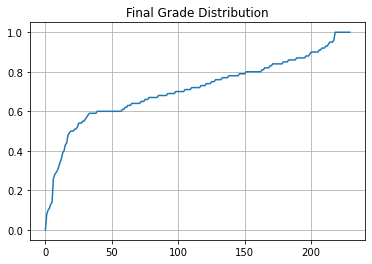

In [324]:
plt.plot(sorted(student_por_df['TGNorm']))
plt.title('Final Grade Distribution')
plt.grid()

##### Exploration and feature engineering

In [325]:
list(student_por_df._get_numeric_data())

['AgeCourseStart',
 'Quiz1Norm',
 'Quiz2Norm',
 'HW1Norm',
 'MTNorm',
 'TGNorm',
 'AGE_ADMITTED',
 'Reg_Hrs',
 'HS_GPA',
 'MATH',
 'PHYS',
 'Repeated_Grade_ITBP119_CSBP119',
 'ITBP119_CSBP119_max',
 'Repeated_Grade_ITBP219_CSBP219',
 'ESPN',
 'CSBP121',
 'MATH105',
 'CENG205',
 'PHYS105',
 'CENG202',
 'CIT',
 'AcademicStanding',
 'Citizenship',
 'Gender',
 'Sponsor',
 'Resident_in_city']

In [326]:
# find all non-numerical data
non_numeric_features = [feat for feat in list(student_por_df) if feat not in list(student_por_df._get_numeric_data())]

for feat in non_numeric_features:
    print(feat, ':', set(student_por_df[feat]))

In [327]:
non_numeric_features

[]

In [328]:
for feat in non_numeric_features:
    dummies = pd.get_dummies(student_por_df[feat]).rename(columns=lambda x: feat + '_' + str(x))
    student_por_df = pd.concat([student_por_df, dummies], axis=1)
    


In [329]:
student_por_df.columns

Index(['AgeCourseStart', 'Quiz1Norm', 'Quiz2Norm', 'HW1Norm', 'MTNorm',
       'TGNorm', 'AGE_ADMITTED', 'Reg_Hrs', 'HS_GPA', 'MATH', 'PHYS',
       'Repeated_Grade_ITBP119_CSBP119', 'ITBP119_CSBP119_max',
       'Repeated_Grade_ITBP219_CSBP219', 'ESPN', 'CSBP121', 'MATH105',
       'CENG205', 'PHYS105', 'CENG202', 'CIT', 'AcademicStanding',
       'Citizenship', 'Gender', 'Sponsor', 'Resident_in_city'],
      dtype='object')

In [330]:
student_por_df = student_por_df[[feat for feat in list(student_por_df) if feat not in non_numeric_features]]
student_por_df.shape

(230, 26)

In [331]:
# create an xgboost model
# run simple xgboost classification model and check 
# prep modeling code
columns=['AgeCourseStart',
 'Quiz1Norm',
 'Quiz2Norm',
 'HW1Norm',
 'MTNorm',
 'AGE_ADMITTED',
 'Reg_Hrs',
 'HS_GPA',
 'MATH',
 'PHYS',
 'Repeated_Grade_ITBP119_CSBP119',
 'ITBP119_CSBP119_max',
 'Repeated_Grade_ITBP219_CSBP219',
 'ESPN',
 'CSBP121',
 'MATH105',
 'CENG205',
 'PHYS105',
 'CENG202',
 'CIT',
 'AcademicStanding',
 'Citizenship',
 'Gender',
 'Sponsor',
 'Resident_in_city']
outcome = 'TGNorm'
features = [feat for feat in list(student_por_df) if feat not in outcome]
features1 = [feat for feat in list(student_por_df) if feat not in outcome]
features2 = [feat for feat in list(student_por_df) if feat  in outcome]

X_train, X_test, y_train, y_test = train_test_split(student_por_df[features], 
                                                 student_por_df[features2], 
                                                 test_size=0.25, 
                                                 random_state=42)




In [332]:
linear = LinearRegression()
linear.fit(X_train, y_train)
preds_linear = linear.predict(student_por_df[features])
preds_linear

array([[0.92429063],
       [0.82736098],
       [0.84969279],
       [0.86611411],
       [0.86743396],
       [0.9541741 ],
       [0.81582294],
       [0.89958919],
       [0.52354705],
       [0.76214846],
       [0.77033944],
       [0.97593126],
       [0.92549476],
       [0.5899496 ],
       [0.77479667],
       [0.54148011],
       [0.71707689],
       [0.9657458 ],
       [0.74713629],
       [0.90428948],
       [0.58482797],
       [0.83403266],
       [0.83187098],
       [0.81660283],
       [0.90297746],
       [0.61438319],
       [0.94616129],
       [0.49204572],
       [0.98886682],
       [0.8066413 ],
       [0.47950866],
       [0.90904851],
       [0.99249735],
       [0.80257826],
       [0.90928217],
       [0.87649194],
       [0.97421609],
       [0.78855297],
       [0.99920307],
       [0.32763304],
       [0.66370956],
       [0.81610288],
       [0.83606556],
       [0.35447473],
       [0.83972081],
       [0.84862849],
       [1.01875114],
       [0.912

In [333]:
import pickle
# save the model to disk
filename1 = 'streamlit_student_grade_prediction1.pkl'
pickle.dump(linear, open(filename, 'wb'))

In [334]:
# load the model from disk
loaded_model = pickle.load(open(filename1, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

In [335]:
preds = linear.predict(student_por_df[features])
preds

array([[0.92429063],
       [0.82736098],
       [0.84969279],
       [0.86611411],
       [0.86743396],
       [0.9541741 ],
       [0.81582294],
       [0.89958919],
       [0.52354705],
       [0.76214846],
       [0.77033944],
       [0.97593126],
       [0.92549476],
       [0.5899496 ],
       [0.77479667],
       [0.54148011],
       [0.71707689],
       [0.9657458 ],
       [0.74713629],
       [0.90428948],
       [0.58482797],
       [0.83403266],
       [0.83187098],
       [0.81660283],
       [0.90297746],
       [0.61438319],
       [0.94616129],
       [0.49204572],
       [0.98886682],
       [0.8066413 ],
       [0.47950866],
       [0.90904851],
       [0.99249735],
       [0.80257826],
       [0.90928217],
       [0.87649194],
       [0.97421609],
       [0.78855297],
       [0.99920307],
       [0.32763304],
       [0.66370956],
       [0.81610288],
       [0.83606556],
       [0.35447473],
       [0.83972081],
       [0.84862849],
       [1.01875114],
       [0.912

In [265]:
# Import the model we are using

#rf = RandomForestRegressor(n_estimators = 500, bootstrap=True,max_depth=50,max_features=4,min_samples_leaf=7,min_samples_split=10,
                           #random_state = 42)

#rf.fit(X_train, y_train)


In [266]:
#preds = rf.predict(student_por_df[features])
#preds

In [267]:
'''cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(rf, student_por_df[features], student_por_df[outcome], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )'''

"cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n\nscores = cross_val_score(rf, student_por_df[features], student_por_df[outcome], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\nscores = absolute(scores)\nprint('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )"

In [268]:
'''prediction=rf.predict(X_test)

from sklearn import metrics
print('R2 Value:',metrics.r2_score(y_test, xg_reg.predict(X_test)))

print('Accuracy',100- (np.mean(np.abs((y_test - prediction) / y_test)) * 100))'''

"prediction=rf.predict(X_test)\n\nfrom sklearn import metrics\nprint('R2 Value:',metrics.r2_score(y_test, xg_reg.predict(X_test)))\n\nprint('Accuracy',100- (np.mean(np.abs((y_test - prediction) / y_test)) * 100))"

In [307]:
student_por_df[features]

,AgeCourseStart,Quiz1Norm,Quiz2Norm,HW1Norm,MTNorm,AGE_ADMITTED,Reg_Hrs,HS_GPA,MATH,PHYS,...,MATH105,CENG205,PHYS105,CENG202,CIT,AcademicStanding,Citizenship,Gender,Sponsor,Resident_in_city
0,19.02,0.72,0.94,0.90,0.95,18,16,1.0000,1.000,1.000,...,0.90,0.90,0.90,0.90,1,1,0,1,1,0
1,20.78,0.61,1.00,0.90,0.83,19,13,0.9780,1.000,1.000,...,0.90,0.90,0.84,0.90,1,1,0,1,1,0
2,24.65,0.90,0.18,1.00,0.90,22,12,0.9560,1.000,1.000,...,0.90,0.98,0.90,0.92,0,1,0,0,1,0
3,20.61,0.64,0.75,0.80,0.98,19,13,1.0000,1.000,1.000,...,0.90,0.90,0.87,0.87,1,1,0,1,1,0
4,17.72,0.00,0.60,0.97,1.00,16,16,0.9557,1.000,1.000,...,0.90,0.90,0.90,0.84,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,20.14,0.00,0.00,0.85,0.00,17,13,0.8550,0.610,0.620,...,0.77,0.77,0.77,0.77,1,1,1,0,0,1
226,19.53,0.20,0.60,0.20,0.45,17,13,0.7710,0.747,0.616,...,0.60,0.00,0.76,0.00,1,0,1,1,0,0
227,19.01,0.93,1.00,1.00,0.90,17,13,0.8050,0.712,0.607,...,0.60,0.77,0.60,0.64,1,1,1,1,0,0
228,19.29,0.56,1.00,0.70,0.48,18,13,0.8677,0.817,0.600,...,0.67,0.67,0.60,0.64,1,1,1,1,0,0


In [308]:
preds_final=pd.DataFrame(preds,columns=['TGNorm'])
preds_final['TGNorm']

0      0.924291
1      0.827361
2      0.849693
3      0.866114
4      0.867434
         ...   
225    0.310323
226    0.451596
227    0.872457
228    0.609233
229    0.883602
Name: TGNorm, Length: 230, dtype: float64

In [309]:
predicted_students_in_trouble=preds_final[preds_final['TGNorm'] <=0.70]

In [310]:
predicted_students_in_trouble

,TGNorm
8,0.523547
13,0.589950
15,0.541480
20,0.584828
25,0.614383
...,...
222,0.686764
224,0.653677
225,0.310323
226,0.451596


In [311]:
# Saving feature names for later use
feature_list = list(columns)
feature_list

['AgeCourseStart',
 'Quiz1Norm',
 'Quiz2Norm',
 'HW1Norm',
 'MTNorm',
 'AGE_ADMITTED',
 'Reg_Hrs',
 'HS_GPA',
 'MATH',
 'PHYS',
 'Repeated_Grade_ITBP119_CSBP119',
 'ITBP119_CSBP119_max',
 'Repeated_Grade_ITBP219_CSBP219',
 'ESPN',
 'CSBP121',
 'MATH105',
 'CENG205',
 'PHYS105',
 'CENG202',
 'CIT',
 'AcademicStanding',
 'Citizenship',
 'Gender',
 'Sponsor',
 'Resident_in_city']

In [274]:
# Get numerical feature importances
'''importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances'''

'importances = list(rf.feature_importances_)\n\nfeature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]\n\nfeature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)\nfeature_importances'

In [275]:
# get dataframe version of important feature for model 
'''rf_fea_imp=pd.DataFrame(feature_importances,
columns=['feature','importance']).sort_values('importance', ascending=False)
rf_fea_imp.head(10)'''

"rf_fea_imp=pd.DataFrame(feature_importances,\ncolumns=['feature','importance']).sort_values('importance', ascending=False)\nrf_fea_imp.head(10)"

In [278]:
#key_features = list(rf_fea_imp['feature'].values[0:10])
#key_features

In [312]:
 key_features=['AgeCourseStart',
 'Quiz1Norm',
 'Quiz2Norm',
 'HW1Norm',
 'MTNorm',
 'AGE_ADMITTED',
 'Reg_Hrs',
 'HS_GPA',
 'MATH',
 'PHYS',
 'Repeated_Grade_ITBP119_CSBP119',
 'ITBP119_CSBP119_max',
 'Repeated_Grade_ITBP219_CSBP219',
 'ESPN',
 'CSBP121',
 'MATH105',
 'CENG205',
 'PHYS105',
 'CENG202',
 'CIT',
 'AcademicStanding',
 'Citizenship',
 'Gender',
 'Sponsor',
 'Resident_in_city']

In [336]:
predicted_students_in_trouble = preds_final[preds_final['TGNorm'] <= 0.70]
excludedList=['CIT','AcademicStanding','Citizenship','Gender','Sponsor','Resident_in_city']
# See which feature they landed well below or well above peers
for index, row in predicted_students_in_trouble.iterrows():
    print('Student ID:', index, ' TGNorm:',row['TGNorm'])
    for feat in key_features:
        fmean=feat+"_mean"
        row_df=student_por_df[features][index:index+1]
        if(feat=="Repeated_Grade_ITBP219_CSBP219" or feat=="Repeated_Grade_ITBP119_CSBP119"):
            if float(row_df[feat])>0:
                print('\t', feat,' :', int(row_df[feat]))
        elif(feat in excludedList):
             print('\t', feat,' :', int(row_df[feat]))
        else:
            if float(row_df[feat]) < np.round(dict_mean[fmean],2):
                print('\t', 'Below:', feat, float(row_df[feat]), 'Class:', 
                      np.round(np.mean(student_por_df[feat]),2))
            if float(row_df[feat]) > np.round(dict_mean[fmean],2):
                print('\t','Above:', feat, float(row_df[feat]), 'Class:', 
                      np.round(np.mean(student_por_df[feat]),2))

Student ID: 8  TGNorm: 0.5235470452806646
	 Below: AgeCourseStart 18.67 Class: 19.57
	 Below: Quiz1Norm 0.53 Class: 0.63
	 Below: Quiz2Norm 0.4 Class: 0.57
	 Below: HW1Norm 0.0 Class: 0.76
	 Below: MTNorm 0.5 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Above: HS_GPA 0.948 Class: 0.89
	 Above: MATH 0.948 Class: 0.83
	 Above: PHYS 0.9940000000000001 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.74 Class: 0.77
	 Below: ESPN 0.7 Class: 0.78
	 Below: CSBP121 0.6 Class: 0.76
	 Below: MATH105 0.6 Class: 0.73
	 Below: CENG205 0.6 Class: 0.78
	 Below: PHYS105 0.67 Class: 0.7
	 Above: CENG202 0.77 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 0
Student ID: 13  TGNorm: 0.5899496034342182
	 Below: AgeCourseStart 18.71 Class: 19.57
	 Below: Quiz1Norm 0.53 Class: 0.63
	 Below: Quiz2Norm 0.4 Class: 0.57
	 Below: HW1Norm 0.55 Class: 0.76
	 Below: MTNorm 0.45 Class: 0.69
	 Below: AGE_ADMITTED

	 CIT  : 0
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 1
	 Resident_in_city  : 1
Student ID: 77  TGNorm: 0.5060126862936877
	 Above: AgeCourseStart 21.23 Class: 19.57
	 Below: Quiz1Norm 0.33 Class: 0.63
	 Above: Quiz2Norm 0.75 Class: 0.57
	 Above: HW1Norm 1.0 Class: 0.76
	 Below: MTNorm 0.57 Class: 0.69
	 Above: AGE_ADMITTED 18.0 Class: 17.47
	 Below: Reg_Hrs 10.0 Class: 13.5
	 Below: HS_GPA 0.847 Class: 0.89
	 Below: MATH 0.73 Class: 0.83
	 Above: PHYS 0.88 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.74 Class: 0.77
	 Repeated_Grade_ITBP219_CSBP219  : 2
	 Above: ESPN 0.84 Class: 0.78
	 Below: CSBP121 0.7 Class: 0.76
	 Below: MATH105 0.67 Class: 0.73
	 Below: CENG205 0.64 Class: 0.78
	 Below: PHYS105 0.6 Class: 0.7
	 Above: CENG202 0.8 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 0
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 82  TGNorm: 0.698537316318623
	 Below: AgeCourseStart 19.37 Class: 19.57
	 Below: Quiz1Norm 0.35 Cl

	 Below: AgeCourseStart 18.79 Class: 19.57
	 Below: Quiz1Norm 0.57 Class: 0.63
	 Below: Quiz2Norm 0.13 Class: 0.57
	 Above: HW1Norm 1.0 Class: 0.76
	 Below: MTNorm 0.4 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Above: HS_GPA 0.905 Class: 0.89
	 Above: MATH 0.8390000000000001 Class: 0.83
	 Above: PHYS 0.8390000000000001 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.67 Class: 0.77
	 Below: ESPN 0.77 Class: 0.78
	 Above: CSBP121 0.8 Class: 0.76
	 Below: MATH105 0.67 Class: 0.73
	 Below: CENG205 0.7 Class: 0.78
	 Below: PHYS105 0.6 Class: 0.7
	 Below: CENG202 0.7 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 0
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 106  TGNorm: 0.6377993635300647
	 Below: AgeCourseStart 18.53 Class: 19.57
	 Below: Quiz1Norm 0.3 Class: 0.63
	 Below: Quiz2Norm 0.4 Class: 0.57
	 Above: HW1Norm 0.95 Class: 0.76
	 Above: MTNorm 0.7 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: R

	 Above: Reg_Hrs 15.0 Class: 13.5
	 Below: HS_GPA 0.868 Class: 0.89
	 Above: MATH 0.89 Class: 0.83
	 Below: PHYS 0.8 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.6 Class: 0.77
	 Above: ESPN 0.87 Class: 0.78
	 Above: CSBP121 0.7759999999999999 Class: 0.76
	 Above: MATH105 0.87 Class: 0.73
	 Below: CENG205 0.6 Class: 0.78
	 Above: PHYS105 0.84 Class: 0.7
	 Below: CENG202 0.7 Class: 0.75
	 CIT  : 0
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 0
Student ID: 130  TGNorm: 0.40856930530591207
	 Above: AgeCourseStart 20.56 Class: 19.57
	 Below: Quiz1Norm 0.0 Class: 0.63
	 Below: Quiz2Norm 0.5 Class: 0.57
	 Below: HW1Norm 0.0 Class: 0.76
	 Above: MTNorm 0.77 Class: 0.69
	 Above: AGE_ADMITTED 18.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Below: HS_GPA 0.8 Class: 0.89
	 Below: MATH 0.7 Class: 0.83
	 Below: PHYS 0.8 Class: 0.82
	 Repeated_Grade_ITBP219_CSBP219  : 2
	 Above: ESPN 0.84 Class: 0.78
	 Below: CSBP121 0.7 Class: 0.76
	 Above: MATH10

	 Below: ESPN 0.7 Class: 0.78
	 Below: CSBP121 0.64 Class: 0.76
	 Above: MATH105 0.77 Class: 0.73
	 Below: CENG205 0.77 Class: 0.78
	 Above: CENG202 0.77 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 0
Student ID: 148  TGNorm: 0.13066290584109858
	 Above: AgeCourseStart 20.6 Class: 19.57
	 Below: Quiz1Norm 0.47 Class: 0.63
	 Below: Quiz2Norm 0.5 Class: 0.57
	 Below: HW1Norm 0.0 Class: 0.76
	 Below: MTNorm 0.0 Class: 0.69
	 Above: AGE_ADMITTED 19.0 Class: 17.47
	 Above: Reg_Hrs 16.0 Class: 13.5
	 Below: HS_GPA 0.809 Class: 0.89
	 Below: MATH 0.8029999999999999 Class: 0.83
	 Below: PHYS 0.772 Class: 0.82
	 Repeated_Grade_ITBP119_CSBP119  : 3
	 Below: ITBP119_CSBP119_max 0.64 Class: 0.77
	 Repeated_Grade_ITBP219_CSBP219  : 2
	 Below: ESPN 0.64 Class: 0.78
	 Below: CSBP121 0.0 Class: 0.76
	 Below: MATH105 0.0 Class: 0.73
	 Below: CENG205 0.74 Class: 0.78
	 Below: PHYS105 0.276 Class: 0.7
	 Below: CENG202 0.0 Class: 0.75

	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 170  TGNorm: 0.31065133317861215
	 Above: AgeCourseStart 20.19 Class: 19.57
	 Below: Quiz1Norm 0.19 Class: 0.63
	 Below: Quiz2Norm 0.38 Class: 0.57
	 Below: HW1Norm 0.5 Class: 0.76
	 Below: MTNorm 0.33 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 12.0 Class: 13.5
	 Below: HS_GPA 0.784 Class: 0.89
	 Below: MATH 0.7 Class: 0.83
	 Below: PHYS 0.75 Class: 0.82
	 Repeated_Grade_ITBP119_CSBP119  : 2
	 Below: ITBP119_CSBP119_max 0.6 Class: 0.77
	 Repeated_Grade_ITBP219_CSBP219  : 3
	 Below: ESPN 0.7 Class: 0.78
	 Below: CSBP121 0.6 Class: 0.76
	 Below: MATH105 0.6 Class: 0.73
	 Below: CENG205 0.77 Class: 0.78
	 Below: PHYS105 0.6 Class: 0.7
	 Above: CENG202 0.87 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 172  TGNorm: 0.6458442941919416
	 Below: AgeCourseStart 18.65 Class: 19.57
	 Above: Quiz1Norm 0.8

	 Below: Quiz2Norm 0.4 Class: 0.57
	 Below: HW1Norm 0.5 Class: 0.76
	 Below: MTNorm 0.58 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Below: HS_GPA 0.82 Class: 0.89
	 Below: MATH 0.75 Class: 0.83
	 Below: PHYS 0.725 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.6 Class: 0.77
	 Below: ESPN 0.74 Class: 0.78
	 Below: CSBP121 0.67 Class: 0.76
	 Below: MATH105 0.7 Class: 0.73
	 Below: CENG205 0.74 Class: 0.78
	 Below: PHYS105 0.67 Class: 0.7
	 Below: CENG202 0.6 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 189  TGNorm: 0.594280412498521
	 Below: AgeCourseStart 18.76 Class: 19.57
	 Below: Quiz1Norm 0.31 Class: 0.63
	 Above: Quiz2Norm 0.8 Class: 0.57
	 Above: HW1Norm 0.8 Class: 0.76
	 Below: MTNorm 0.43 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Below: HS_GPA 0.833 Class: 0.89
	 Below: MATH 0.733 Class: 0.83
	 Below: PHYS 0.

	 Below: MATH 0.6779999999999999 Class: 0.83
	 Below: PHYS 0.691 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.74 Class: 0.77
	 Repeated_Grade_ITBP219_CSBP219  : 2
	 Below: ESPN 0.77 Class: 0.78
	 Above: CSBP121 0.84 Class: 0.76
	 Below: MATH105 0.7 Class: 0.73
	 Above: CENG205 0.9 Class: 0.78
	 Below: PHYS105 0.64 Class: 0.7
	 Below: CENG202 0.7 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 0
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 206  TGNorm: 0.5908858119957336
	 Below: AgeCourseStart 19.38 Class: 19.57
	 Below: Quiz1Norm 0.25 Class: 0.63
	 Above: Quiz2Norm 0.81 Class: 0.57
	 Below: HW1Norm 0.5 Class: 0.76
	 Below: MTNorm 0.68 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Below: HS_GPA 0.865 Class: 0.89
	 Below: MATH 0.674 Class: 0.83
	 Below: PHYS 0.691 Class: 0.82
	 Below: ITBP119_CSBP119_max 0.74 Class: 0.77
	 Above: ESPN 0.9 Class: 0.78
	 Above: CSBP121 0.8 Class: 0.76
	 Below: MATH105 0.6 Class: 0

	 Above: MATH105 0.84 Class: 0.73
	 Below: CENG205 0.6 Class: 0.78
	 Below: PHYS105 0.67 Class: 0.7
	 Above: CENG202 0.77 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0
	 Resident_in_city  : 1
Student ID: 219  TGNorm: 0.5586042168472316
	 Above: AgeCourseStart 19.71 Class: 19.57
	 Below: Quiz1Norm 0.5 Class: 0.63
	 Below: Quiz2Norm 0.4 Class: 0.57
	 Below: HW1Norm 0.7 Class: 0.76
	 Below: MTNorm 0.28 Class: 0.69
	 Below: AGE_ADMITTED 17.0 Class: 17.47
	 Below: Reg_Hrs 13.0 Class: 13.5
	 Below: HS_GPA 0.789 Class: 0.89
	 Below: MATH 0.74 Class: 0.83
	 Below: PHYS 0.639 Class: 0.82
	 Repeated_Grade_ITBP119_CSBP119  : 2
	 Below: ITBP119_CSBP119_max 0.67 Class: 0.77
	 Above: ESPN 0.84 Class: 0.78
	 Below: CSBP121 0.0 Class: 0.76
	 Above: MATH105 0.9 Class: 0.73
	 Below: CENG205 0.67 Class: 0.78
	 Below: PHYS105 0.67 Class: 0.7
	 Below: CENG202 0.74 Class: 0.75
	 CIT  : 1
	 AcademicStanding  : 1
	 Citizenship  : 1
	 Gender  : 1
	 Sponsor  : 0


In [314]:
len(predicted_students_in_trouble)

102

In [315]:
 #for feat in key_features:
       # print(feat,student_por_df[feat].quantile(0.25))

In [122]:
'''MTNorm_25 =0.55
HW1Norm_25 =0.6124999999999999
Quiz1Norm_25 =0.5075000000000001
CSBP121_25= 0.67
Repeated_Grade_ITBP219_CSBP219_25 =0.0
ITBP119_CSBP119_max_25 =0.7
CENG202_25 =0.7
PHYS105_25= 0.6
CENG205_25= 0.7027083332499999
ESPN_25 =0.7'''


In [131]:
'''dict_25 = {}

dict_25["MTNorm_25"] =0.55
dict_25["HW1Norm_25"] =0.6124999999999999
dict_25["Quiz1Norm_25"] =0.5075000000000001
dict_25["CSBP121_25"]= 0.67
dict_25["Repeated_Grade_ITBP219_CSBP219_25"] =0.0
dict_25["ITBP119_CSBP119_max_25"] =0.7
dict_25["CENG202_25"] =0.7
dict_25["PHYS105_25"]= 0.6
dict_25["CENG205_25"]= 0.7027083332499999
dict_25["ESPN_25"] =0.7'''

In [337]:
for feat in key_features:
    print(feat,np.round(np.mean(student_por_df[feat]),2))

AgeCourseStart 19.57
Quiz1Norm 0.63
Quiz2Norm 0.57
HW1Norm 0.76
MTNorm 0.69
AGE_ADMITTED 17.47
Reg_Hrs 13.5
HS_GPA 0.89
MATH 0.83
PHYS 0.82
Repeated_Grade_ITBP119_CSBP119 0.2
ITBP119_CSBP119_max 0.77
Repeated_Grade_ITBP219_CSBP219 0.24
ESPN 0.78
CSBP121 0.76
MATH105 0.73
CENG205 0.78
PHYS105 0.7
CENG202 0.75
CIT 0.91
AcademicStanding 0.95
Citizenship 0.92
Gender 0.74
Sponsor 0.15
Resident_in_city 0.5


In [317]:
AgeCourseStart_mean= 19.57
Quiz1Norm_mean= 0.63
Quiz2Norm_mean= 0.57
HW1Norm_mean= 0.76
MTNorm_mean= 0.69
AGE_ADMITTED_mean= 17.47
Reg_Hrs_mean= 13.5
HS_GPA_mean= 0.89
MATH_mean= 0.83
PHYS_mean= 0.82
ITBP119_CSBP119_max_mean= 0.77
ESPN_mean= 0.78
CSBP121_mean= 0.76
MATH105_mean= 0.73
CENG205_mean= 0.78
PHYS105_mean= 0.7
CENG202_mean= 0.75


In [318]:
dict_mean = {}


dict_mean["AgeCourseStart_mean"]= 19.57
dict_mean["Quiz1Norm_mean"]= 0.63
dict_mean["Quiz2Norm_mean"]= 0.57
dict_mean["HW1Norm_mean"]= 0.76
dict_mean["MTNorm_mean"]= 0.69
dict_mean["AGE_ADMITTED_mean"]= 17.47
dict_mean["Reg_Hrs_mean"]= 13.5
dict_mean["HS_GPA_mean"]= 0.89
dict_mean["MATH_mean"]= 0.83
dict_mean["PHYS_mean"]= 0.82
dict_mean["ITBP119_CSBP119_max_mean"]= 0.77
dict_mean["ESPN_mean"]= 0.78
dict_mean["CSBP121_mean"]= 0.76
dict_mean["MATH105_mean"]= 0.73
dict_mean["CENG205_mean"]= 0.78
dict_mean["PHYS105_mean"]= 0.7
dict_mean["CENG202_mean"]= 0.75

